# CS 565 Analysis - StackOverflow Newcomers
[View the notebook on nbviewer instead.](https://nbviewer.org/github/jackiec1998/cs565-final-project/blob/main/newcomers.ipynb?flush_cache=false)

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Data Ingestion

In [2]:
newcomers = pd.read_csv('newcomers.csv', parse_dates=['FirstPostDate', 'AccountCreationDate'])
year = pd.read_csv('numPostsWithinYear.csv')
two_posts = pd.read_csv('timeBetweenFirstTwo.csv', parse_dates=['FirstPostDate', 'SecondPostDate'])

## Data Preprocessing

In [3]:
def normalize(column, df):
    return df[column] / df['NumInitialPosts']

newcomers['Lurking'] = (newcomers['FirstPostDate'] - newcomers['AccountCreationDate']).dt.days

newcomers['AvgUpVotes'] = normalize('TotalUpVotes', newcomers)
newcomers['AvgDownVotes'] = normalize('TotalDownVotes', newcomers)
newcomers['AvgAcceptances'] = normalize('TotalAnswersAccepted', newcomers)
newcomers['AvgBookmarks'] = normalize('TotalBookmarked', newcomers)
newcomers['AvgClosed'] = normalize('TotalClosed', newcomers)
newcomers['AvgDeleted'] = normalize('TotalDeleted', newcomers)
newcomers['AvgSpam'] = normalize('TotalMarkedAsSpam', newcomers)

newcomers['AvgNumEdits'] = normalize('TotalSuggestedEdits', newcomers)
newcomers['NumAnswers'] = newcomers['NumInitialPosts'] - newcomers['NumQuestions']

newcomers['Retained'] = (newcomers['NumFuturePosts'] > 0).astype(int)

In [7]:
def show_columns(df):
    return df.dtypes.to_frame().rename(columns={0: 'Type'})

show_columns(newcomers)

,Type
UserId,int64
AccountCreationDate,datetime64[ns]
FirstPostDate,datetime64[ns]
NumInitialPosts,int64
NumQuestions,int64
AvgViewCount,float64
AvgNumAnswers,float64
AvgTopAnswererRep,float64
AvgTopAnswererAge,float64
TotalSuggestedEdits,int64


## Number of Posts Stack Overflow Users Make During Their First Year

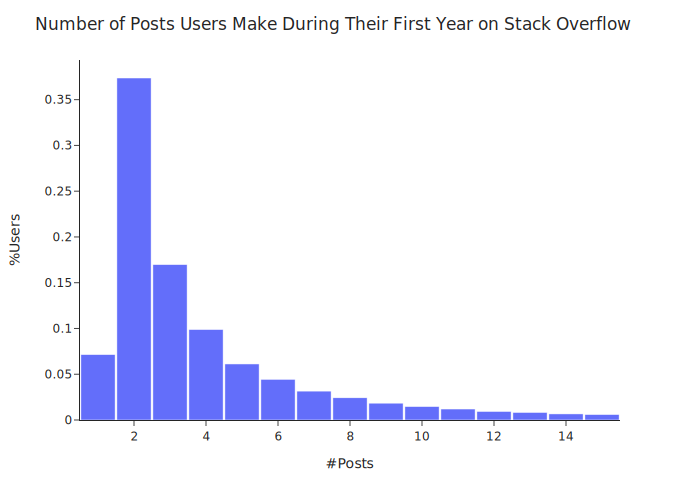

In [5]:
X_MAX_RANGE = 15

fig = px.bar(year['NumPosts'].value_counts().sort_index() / len(year))

fig.update_xaxes(
    range=[0.5, X_MAX_RANGE + 0.5],
    showgrid=False
)

fig.update_yaxes(
    showgrid=False
)

fig.update_layout(
    template='simple_white',
    bargap=0.05,
    showlegend=False,
    title='Number of Posts Users Make During Their First Year on Stack Overflow',
    xaxis_title='#Posts',
    yaxis_title='%Users',
)

fig.show('svg')
fig.write_image('figs/num-posts-year.png', scale=3)

## Distribution of Newcomer's Initial Posts and Future Posts

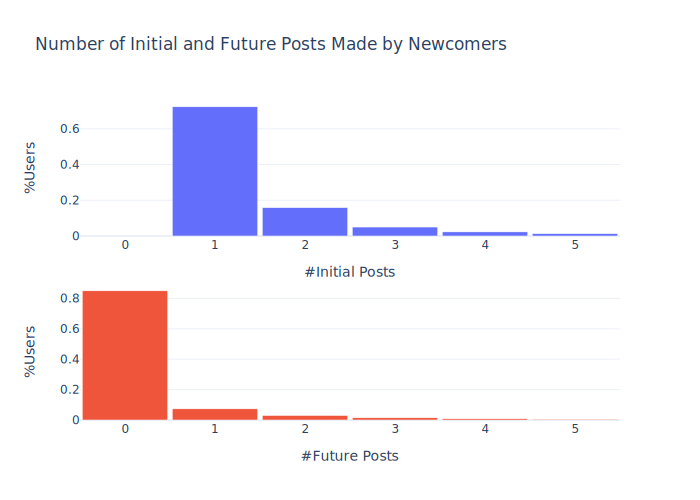

In [6]:
X_MAX_RANGE = 5

fig = make_subplots(rows=2, cols=1)

# Initial Posts
initial_dist = newcomers['NumInitialPosts'].value_counts().sort_index() / len(newcomers)

fig.add_trace(
    go.Bar(x=initial_dist.index, y=initial_dist.values),
    row=1, col=1
)

fig.update_xaxes(
    title_text='#Initial Posts',
    row=1, col=1
)

fig.update_yaxes(
    title_text='%Users',
    row=1, col=1
)

# Future Posts
future_dist = newcomers['NumFuturePosts'].value_counts().sort_index() / len(newcomers)

fig.add_trace(
    go.Bar(x=future_dist.index, y=future_dist.values),
    row=2, col=1
)

fig.update_xaxes(
    title_text='#Future Posts',
    row=2, col=1
)

fig.update_yaxes(
    title_text='%Users',
    row=2, col=1
)

fig.update_xaxes(
    range=[-0.5, X_MAX_RANGE + 0.5]
)

fig.update_layout(
    template='plotly_white',
    bargap=0.05,
    showlegend=False,
    title='Number of Initial and Future Posts Made by Newcomers',
)

fig.show('svg')
fig.write_image('figs/num-initial-future.png', scale=3)

## Whether Newcomers Experience Particular Features

In [109]:
properties = [
    ('TotalSuggestedEdits', 'Edited Post'),
    ('TotalClosed', 'Closed Question'),
    ('TotalAnswersAccepted', 'Accepted Answer'),
    ('TotalBookmarked', 'Bookmarked Post'),
    ('TotalDeleted', 'Deleted Post'),
    ('TotalMarkedAsSpam', 'Spam Post')
]

table = {}

for property, name in properties:
    table[name] = {
        '%Experienced': len(newcomers[newcomers[property] > 0]) / len(newcomers),
        '#Experienced': len(newcomers[newcomers[property] > 0]),
        '%Did Not Experience': len(newcomers[newcomers[property] == 0]) / len(newcomers),
        '#Did Not Experience': len(newcomers[newcomers[property] == 0])
    }

pd.DataFrame.from_dict(table, orient='index')

,%Experienced,#Experienced,%Did Not Experience,#Did Not Experience
Edited Post,0.185347,32111,0.814653,141137
Closed Question,0.000000,0,1.000000,173248
Accepted Answer,0.073807,12787,0.926193,160461
Bookmarked Post,0.056878,9854,0.943122,163394
Deleted Post,0.006973,1208,0.993027,172040
Spam Post,0.000000,0,1.000000,173248


## Percentage of Users Retained (i.e., Posted During Retention Period)

In [134]:
properties = [
    (np.ones(len(newcomers)).astype(bool), 'All Newcomers'),
    (newcomers['TotalSuggestedEdits'] > 0, 'Newcomers with Edits'),
    (newcomers['NumQuestions'] > 0, 'Newcomers with Questions'),
    (newcomers['NumAnswers'] > 0, 'Newcomers with Answers')
]

table = {}

for filter, name in properties:
    table[name] = {
        '%Retained': (newcomers[filter]['Retained'].value_counts()[1] / len(newcomers)).round(3) * 100,
        '#Retained': newcomers[filter]['Retained'].value_counts()[1],
        '%Not Retained': (newcomers[filter]['Retained'].value_counts()[0] / len(newcomers)).round(3) * 100,
        '#Not Retained': newcomers[filter]['Retained'].value_counts()[0],
        'Total Newcomers': len(newcomers[filter])
    }

pd.DataFrame.from_dict(table, orient='index')

,%Retained,#Retained,%Not Retained,#Not Retained,Total Newcomers
All Newcomers,15.0,26015,85.0,147233,173248
Newcomers with Edits,3.0,5244,15.5,26867,32111
Newcomers with Questions,11.8,20432,63.6,110142,130574
Newcomers with Answers,5.8,9997,29.7,51451,61448


## Utility Functions

In [32]:
def log_odds(model, only_significant=False):
    odds = model.conf_int()
    odds['Odds Ratio'] = model.params
    odds.columns = ['5%', '95%', 'Odds Ratio']
    odds = np.exp(odds)
    odds['Significant'] = model.pvalues < 0.05

    if only_significant:
        odds = odds[odds['Significant'] == True]

    return odds

def format_formula(dict):
    return f'{dict["Dependent"]} ~ ' + ' + '.join(dict["Independent"])

## All Posts Logistic Regression
At a high level, the upvotes have less effect on retention compared to negative signals: downvotes and deleted. Additionally, the number of edits behaves like a negative influence on retention---it has a greater impact on retention than an individual downvote!

Bookmarks weren't statistically significant and lurking doesn't have a practical influence on newcomer retention.

In [39]:
all_variables = {
    'Dependent': 'Retained',
    'Independent': [
        'AvgUpVotes',
        'AvgDownVotes',
        'AvgBookmarks',
        'AvgDeleted',
        'AvgNumEdits',
        'Lurking'
    ]
}

model = smf.logit(
    formula=format_formula(all_variables),
    data=newcomers
).fit(disp=False)

display(model.summary())
display(log_odds(model))

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Retained   No. Observations:               173248
Model:                          Logit   Df Residuals:                   173241
Method:                           MLE   Df Model:                            6
Date:                Tue, 05 Apr 2022   Pseudo R-squ.:               0.0009717
Time:                        15:02:42   Log-Likelihood:                -73210.
converged:                       True   LL-Null:                       -73282.
Covariance Type:            nonrobust   LLR p-value:                 3.091e-28
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.7127      0.009   -199.167      0.000      -1.730      -1.696
AvgUpVotes       0.0096      0.003      3.096      0.002       0.004       0.016
AvgDownVotes    -0.0543      0.012     -4.623      0.000      -0.077      -0.031
AvgBookmarks    -0.0177      0.023     -0.763      0.445      -0.063       0.028
AvgDeleted      -0.3706      0.122     -3.044      0.002      -0.609      -0.132
AvgNumEdits     -0.1647      0.020     -8.393      0.000      -0.203      -0.126
Lurking       4.337e-05   1.19e-05      3.640      0.000       2e-05    6.67e-05
================================================================================
"""

,5%,95%,Odds Ratio,Significant
Intercept,0.177367,0.183447,0.180381,True
AvgUpVotes,1.003535,1.015831,1.009664,True
AvgDownVotes,0.925567,0.969192,0.947128,True
AvgBookmarks,0.938959,1.028057,0.982498,False
AvgDeleted,0.543773,0.876334,0.690309,True
AvgNumEdits,0.816173,0.881422,0.848170,True
Lurking,1.000020,1.000067,1.000043,True


## Edited Posts Logistic Regression
With edited posts, upvotes, downvotes, and deletions cease to be statistically significant. However, the number of edits have an even greater effect on this filtered set compared to the logistic regression on all posts.

For regression-specific variables, the reputation of the editor isn't statistically significant and the age is statistically significant, but the effect size isn't noteworthy.

In [40]:
edit_variables = {
    'Dependent': 'Retained',
    'Independent': all_variables['Independent'] + [
        'AvgEditorRep',
        'AvgEditorAge'
    ]
}

model = smf.logit(
    formula=format_formula(edit_variables),
    data=newcomers[newcomers['TotalSuggestedEdits'] > 0]
).fit(disp=False)

display(model.summary())
display(log_odds(model))

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Retained   No. Observations:                32111
Model:                          Logit   Df Residuals:                    32102
Method:                           MLE   Df Model:                            8
Date:                Tue, 05 Apr 2022   Pseudo R-squ.:                 0.03838
Time:                        15:02:45   Log-Likelihood:                -13745.
converged:                       True   LL-Null:                       -14293.
Covariance Type:            nonrobust   LLR p-value:                1.688e-231
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.5132      0.042    -12.347      0.000      -0.595      -0.432
AvgUpVotes       0.0083      0.005      1.667      0.095      -0.001       0.018
AvgDownVotes    -0.0386      0.027     -1.454      0.146      -0.091       0.013
AvgBookmarks    -0.0139      0.054     -0.257      0.797      -0.120       0.092
AvgDeleted      -0.4207      0.296     -1.423      0.155      -1.000       0.159
AvgNumEdits     -1.3492      0.043    -31.266      0.000      -1.434      -1.265
Lurking       5.116e-05   3.13e-05      1.635      0.102   -1.02e-05       0.000
AvgEditorRep -1.181e-05   6.65e-06     -1.776      0.076   -2.49e-05    1.23e-06
AvgEditorAge -5.807e-05   1.61e-05     -3.598      0.000   -8.97e-05   -2.64e-05
================================================================================
"""

,5%,95%,Odds Ratio,Significant
Intercept,0.551727,0.649365,0.598559,True
AvgUpVotes,0.998548,1.018165,1.008309,False
AvgDownVotes,0.913431,1.013495,0.962163,False
AvgBookmarks,0.887129,1.096324,0.986196,False
AvgDeleted,0.367837,1.171901,0.656558,False
AvgNumEdits,0.238418,0.282358,0.259460,True
Lurking,0.999990,1.000113,1.000051,False
AvgEditorRep,0.999975,1.000001,0.999988,False
AvgEditorAge,0.999910,0.999974,0.999942,True


## Questions Logisitic Regression
With questions, upvotes and downvotes are statistically significant, but with upvotes its effect is only minor. A single downvote, however, has a significant effect on newcomer retention rate.

This is the first regression where bookmarks are statistically significant, but they act as a negative influence on newcomer retention---greater than individual downvotes.

The number of edits still negatively impacts newcomer retention rate.

For regression-specific variables (e.g., top answerer age, reputation, number of answers), they're either have miniscule effect sizes (see top answerer age, reputation) or aren't statistically significant (see average number of answers).

In [41]:
question_variables = {
    'Dependent': 'Retained',
    'Independent': all_variables['Independent'] + [
        'AvgTopAnswererRep',
        'AvgTopAnswererAge',
        'AvgNumAnswers',
        'AvgViewCount'
    ]
}

# Problem?: Even though this is the question regression, the
# averages are still affected by answers.
model = smf.logit(
    formula=format_formula(question_variables),
    data=newcomers[newcomers['NumQuestions'] > 0]
).fit(disp=False)

display(model.summary())
display(log_odds(model))

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Retained   No. Observations:               102588
Model:                          Logit   Df Residuals:                   102577
Method:                           MLE   Df Model:                           10
Date:                Tue, 05 Apr 2022   Pseudo R-squ.:                0.002398
Time:                        15:02:48   Log-Likelihood:                -46526.
converged:                       True   LL-Null:                       -46638.
Covariance Type:            nonrobust   LLR p-value:                 1.816e-42
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.5155      0.021    -72.483      0.000      -1.556      -1.474
AvgUpVotes            0.0216      0.007      3.140      0.002       0.008       0.035
AvgDownVotes         -0.1244      0.013     -9.565      0.000      -0.150      -0.099
AvgBookmarks         -0.1151      0.031     -3.750      0.000      -0.175      -0.055
AvgDeleted            0.0451      0.146      0.310      0.757      -0.240       0.330
AvgNumEdits          -0.1719      0.024     -7.261      0.000      -0.218      -0.125
Lurking            6.034e-05   1.69e-05      3.566      0.000    2.72e-05    9.35e-05
AvgTopAnswererRep   2.54e-07    6.6e-08      3.848      0.000    1.25e-07    3.83e-07
AvgTopAnswererAge -3.612e-05   7.74e-06     -4.666      0.000   -5.13e-05   -2.09e-05
AvgNumAnswers         0.0082      0.012      0.662      0.508      -0.016       0.032
AvgViewCount       5.386e-06   2.64e-06      2.042      0.041    2.17e-07    1.06e-05
=====================================================================================
"""

,5%,95%,Odds Ratio,Significant
Intercept,0.210884,0.228896,0.219706,True
AvgUpVotes,1.008136,1.035636,1.021793,True
AvgDownVotes,0.860765,0.905798,0.882995,True
AvgBookmarks,0.839227,0.946539,0.891270,True
AvgDeleted,0.786567,1.391388,1.046145,False
AvgNumEdits,0.803897,0.882069,0.842077,True
Lurking,1.000027,1.000094,1.000060,True
AvgTopAnswererRep,1.000000,1.000000,1.000000,True
AvgTopAnswererAge,0.999949,0.999979,0.999964,True
AvgNumAnswers,0.984051,1.033001,1.008229,False


## Answers Logistic Regression
Upvotes aren't statistically significant, but downvotes are still have a strong negative relationship with newcomer retention.

Again, bookmarks are still a negative factor, not sure why.

Deletions and number of edits are negative factors as well, particular emphasis on deletions given its exceedingly negative relationship with newcomer retention.

In contrast, the average number of acceptances is a strong positive factor in newcomer retention.

In [43]:
answer_variables = {
    'Dependent': 'Retained',
    'Independent': all_variables['Independent'] + [
        'AvgAcceptances'
    ]
}

model = smf.logit(
    formula=format_formula(answer_variables),
    data=newcomers[newcomers['NumAnswers'] > 0]
).fit(disp=False)

display(model.summary())
display(log_odds(model))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Retained   No. Observations:                61448
Model:                          Logit   Df Residuals:                    61440
Method:                           MLE   Df Model:                            7
Date:                Tue, 05 Apr 2022   Pseudo R-squ.:                0.003376
Time:                        15:11:00   Log-Likelihood:                -27197.
converged:                       True   LL-Null:                       -27289.
Covariance Type:            nonrobust   LLR p-value:                 2.487e-36
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.6398      0.015   -109.754      0.000      -1.669      -1.610
AvgUpVotes         0.0047      0.003      1.397      0.163      -0.002       0.011
AvgDownVotes      -0.0821      0.033     -2.521      0.012      -0.146      -0.018
AvgBookmarks       0.1038      0.085      1.221      0.222      -0.063       0.270
AvgDeleted        -0.8409      0.211     -3.985      0.000      -1.255      -0.427
AvgNumEdits       -0.3127      0.044     -7.111      0.000      -0.399      -0.226
Lurking        -1.112e-05   1.71e-05     -0.651      0.515   -4.46e-05    2.24e-05
AvgAcceptances     0.3774      0.041      9.095      0.000       0.296       0.459
==================================================================================
"""

,5%,95%,Odds Ratio,Significant
Intercept,0.188426,0.199791,0.194025,True
AvgUpVotes,0.998118,1.011285,1.004680,False
AvgDownVotes,0.864232,0.981901,0.921189,True
AvgBookmarks,0.939126,1.310403,1.109340,False
AvgDeleted,0.285214,0.652252,0.431313,True
AvgNumEdits,0.671087,0.797323,0.731487,True
Lurking,0.999955,1.000022,0.999989,False
AvgAcceptances,1.344610,1.582136,1.458546,True
